In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import sklearn as sk
from dotenv import load_dotenv
import time
import re


In [10]:
def read_data():
    load_dotenv()
    API_key = os.getenv('ALPHAVANTAGE_API_KEY')

    symbols = ["AAPL", "MSFT", "SPY", "TSLA", "GOOGL", "AMZN", "META"]

    base_url = "https://www.alphavantage.co/query"

    all_data = []  # List to store each symbol's data

    for symbol in symbols:
        print(f"Downloading weekly data for {symbol}...")

        params = {
            "function": "TIME_SERIES_WEEKLY_ADJUSTED",
            "symbol": symbol,
            "apikey": API_key
        }

        for attempt in range(3):
            r = requests.get(base_url, params=params)
            try:
                data = r.json()
                break
            except ValueError:
                print(f"Invalid response for {symbol}, attempt {attempt+1}")
                print("Raw response:", r.text[:200])
                time.sleep(15)
        else:
            print(f"Failed to get valid JSON for {symbol}, skipping...")
            continue

        if "Weekly Adjusted Time Series" not in data:
            print(f"Error for {symbol}: {data}")
            time.sleep(15)
            continue

        df = pd.DataFrame(data["Weekly Adjusted Time Series"]).T

        # Keep default integer index, create new column 'Date'
        df['Date'] = pd.to_datetime(df.index)

        # Sort by Date if needed
        df = df.sort_values('Date')

        df = df[df['Date'].between(pd.Timestamp("2015-12-04"), pd.Timestamp("2020-12-04"))]

        df['Symbol'] = symbol
        df.reset_index(drop=True, inplace=True)  # Drop old string index

        all_data.append(df)
        time.sleep(15)
    return df


In [ ]:
def combine_data():
    df1 = pd.read_csv("weekly_5yr_all_symbols.csv")
    df2 = pd.read_csv("weekly_5yr_all_symbols_pt_2.csv")

    # Clean column names (remove leading numbers like "1. Price")
    df1.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df1.columns]
    df2.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df2.columns]

    # Reorder columns of df1
    df1 = df1[['Symbol', 'Date'] + [col for col in df1.columns if col not in ['Symbol', 'Date']]]

    # Reorder df2 the same way to guarantee matching column order
    df2 = df2[df1.columns]

    # Combine the two
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

In [11]:
def cleaning_pipeline(df):
    df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

    # Clean column names (remove numbers like "1. open")
    df.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df.columns]

    # Reorder columns
    df = df[['Symbol', 'Date'] + [col for col in df.columns if col not in ['Symbol', 'Date']]]
    df['close'] = df['close'].astype(float)

    # Sort by Symbol and Date to make sure diff works correctly
    df = df.sort_values(['Symbol', 'Date'])

    # Create a new column with difference from previous close
    df['Close_diff'] = df.groupby('Symbol')['close'].diff()
    
    #Percentage Change from Beginning
    df['Pct_Change'] = df.groupby('Symbol')['adjusted close'].transform(
        lambda x: (x / x.iloc[0] - 1) * 100
    )


In [31]:
def plot_closing_prices(df):
    df['Date'] = pd.to_datetime(df['Date'])
    symbols = df['Symbol'].unique()

    for sym in symbols:
        sub = df[df['Symbol'] == sym]

        plt.figure(figsize=(10,4))
        plt.plot(sub['Date'], sub['adjusted close'])
        plt.title(f"Closing Price Over Time: {sym}")
        plt.ylabel("Closing Price")
        plt.tight_layout()
        years = sorted(sub['Date'].dt.year.unique())
        tick_locs = [pd.Timestamp(f'{y}-01-01') for y in years]
        plt.xticks(ticks=tick_locs, labels=years, rotation=45)
        plt.show()

# Create a new column with difference from previous close
df['Close_diff'] = df.groupby('Symbol')['close'].diff()

numeric_cols = [
    'open', 'high', 'low', 'close',
    'adjusted close', 'volume',
    'dividend amount'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [13]:
df.head()

,Symbol,Date,open,high,low,close,adjusted close,volume,dividend amount,Close_diff
0,AAPL,2020-11-27,117.1800,117.6202,112.5900,116.590,113.5067,364376131,0.0000,NaN
1,AAPL,2020-12-04,116.9700,123.7800,116.8100,122.250,119.0171,541563385,0.0000,5.660
2,AAPL,2020-12-11,122.3100,125.9500,120.1500,122.410,119.1728,452278651,0.0000,0.160
3,AAPL,2020-12-18,122.6000,129.5800,121.5400,126.655,123.3056,621758148,0.0000,4.245
4,AAPL,2020-12-24,125.0200,134.4050,123.4490,131.970,128.4800,433757134,0.0000,5.315


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[['close', 'volume']]
Y = df['adjusted close']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

print(df.dtypes)

Coefficients: [-3.46916684e-02 -1.75896707e-07]
Intercept: 309.9287560715111
Symbol                     object
Date               datetime64[ns]
open                      float64
high                      float64
low                       float64
close                     float64
adjusted close            float64
volume                      int64
dividend amount           float64
Close_diff                float64
dtype: object


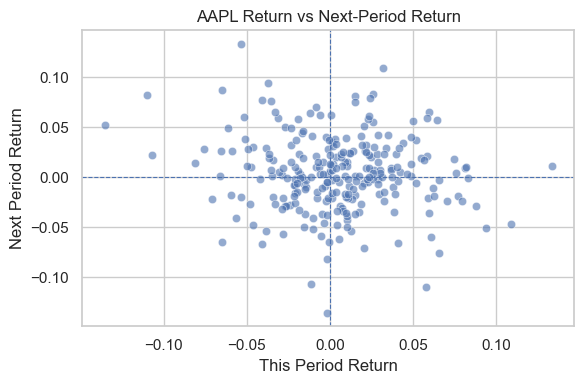

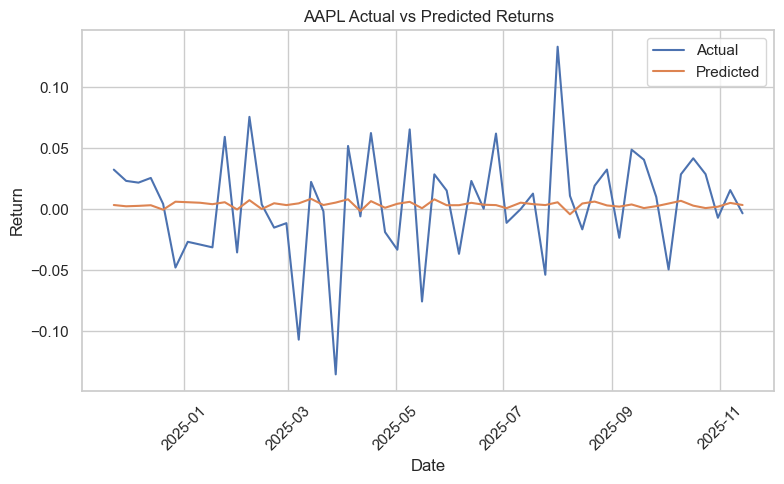

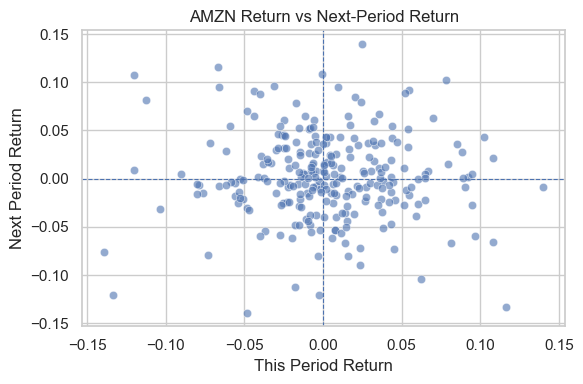

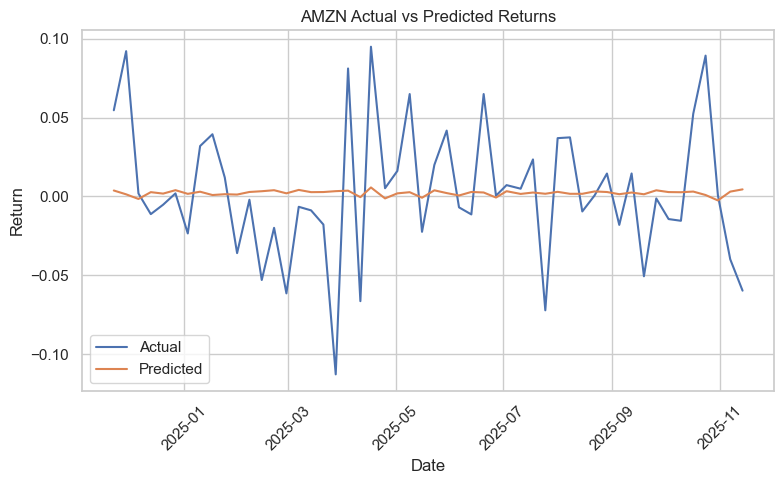

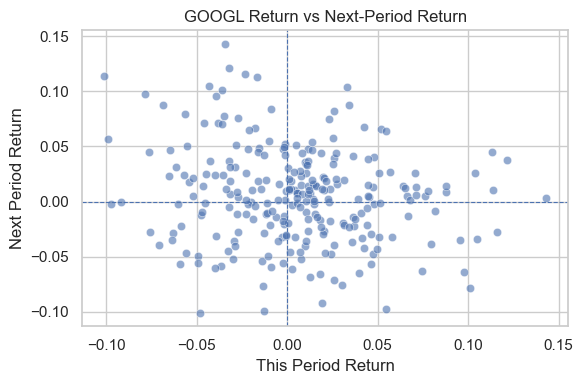

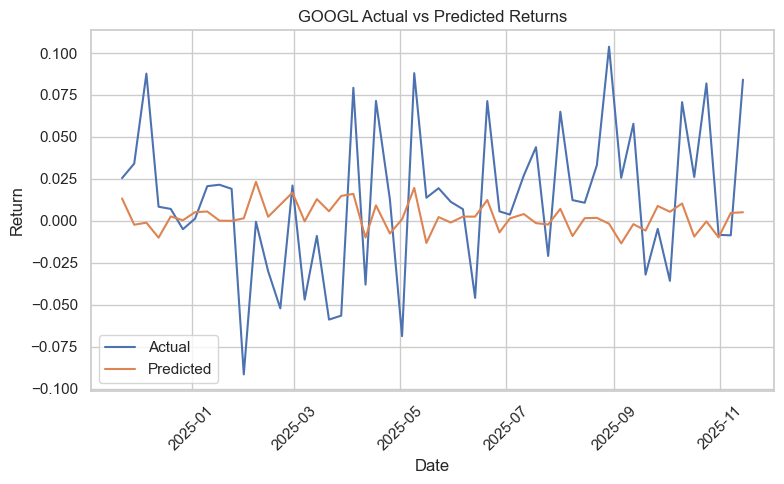

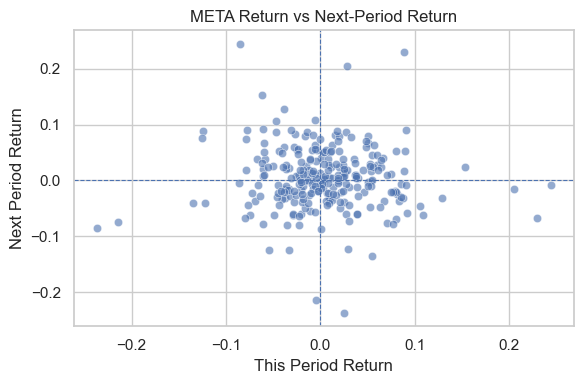

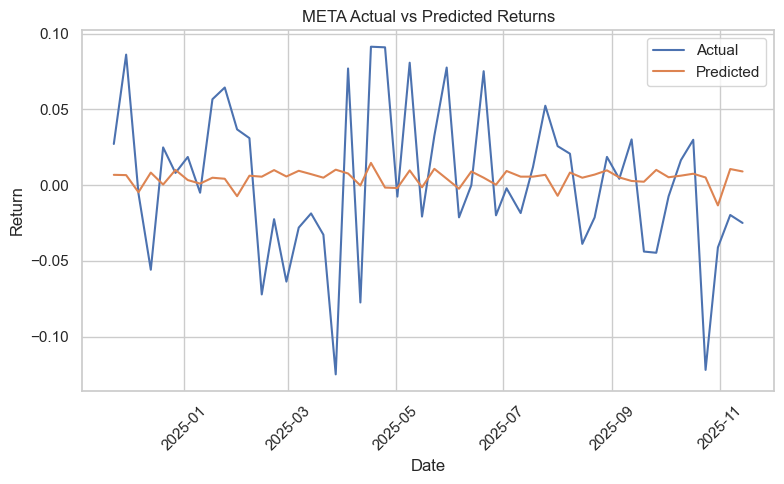

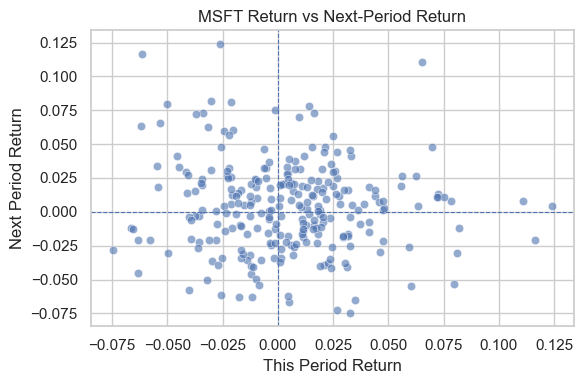

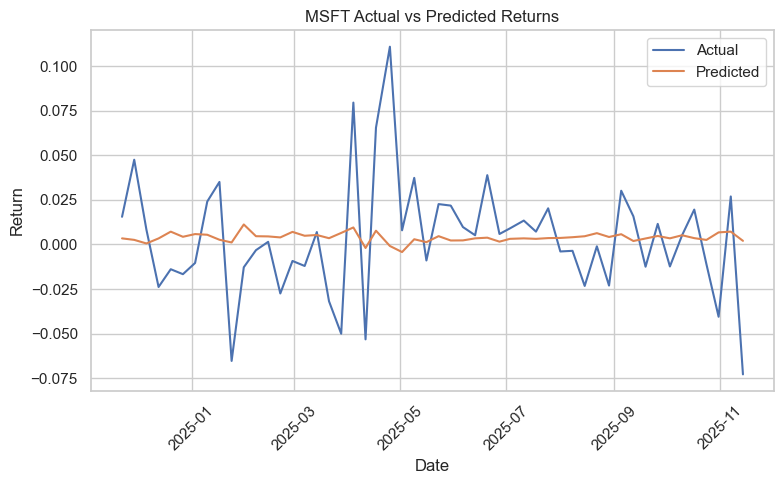

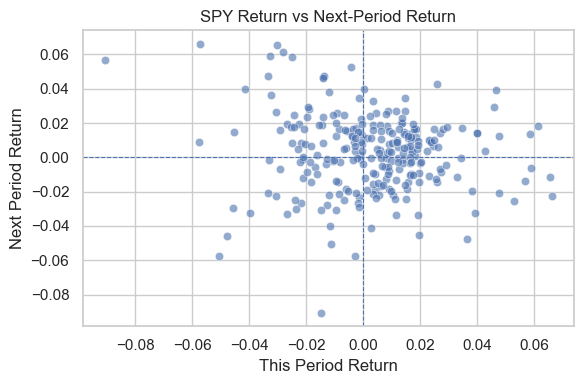

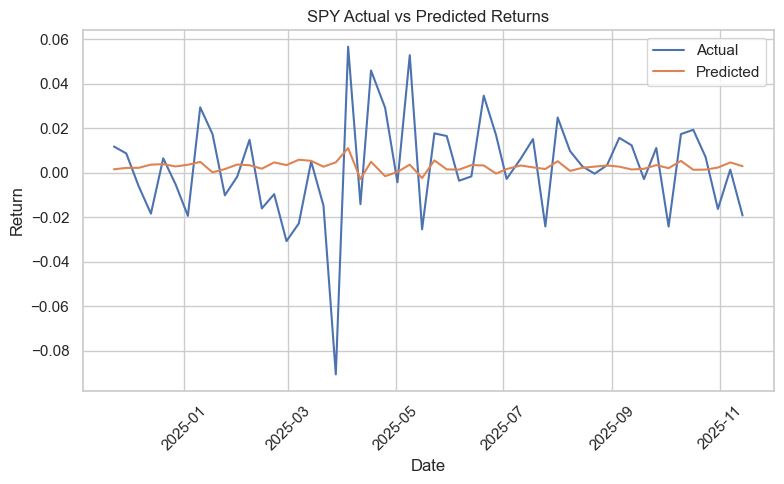

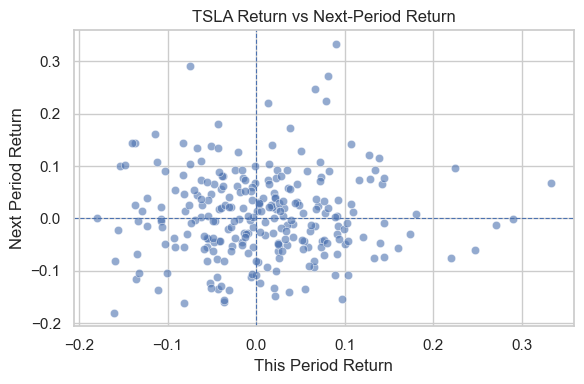

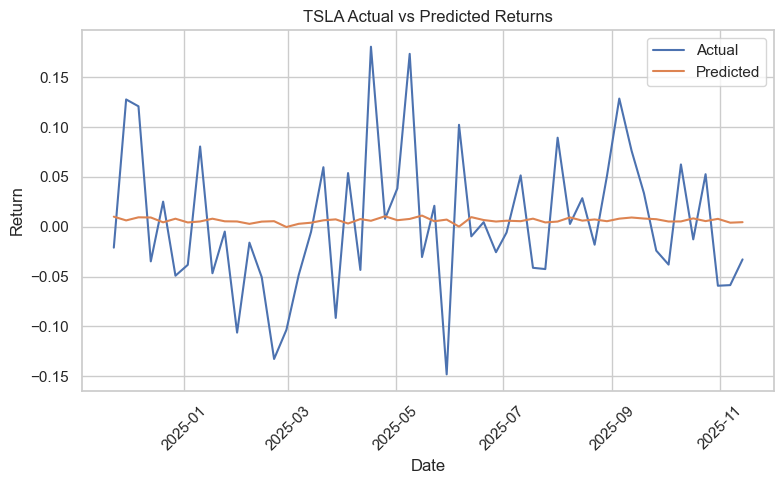

,Symbol,coef_ret,coef_vol_change,intercept,r2,mse,n_obs
0,AAPL,-0.053296,-0.003501,0.004148,0.016717,0.002009,259
1,AMZN,-0.031144,-0.002173,0.002435,0.006642,0.001826,259
2,GOOGL,-0.188757,0.003411,0.003999,-0.043740,0.002064,259
3,META,-0.056047,-0.007639,0.005901,-0.002361,0.002479,259
4,MSFT,-0.084110,0.001594,0.004181,0.001849,0.001066,259
5,SPY,-0.097055,-0.000695,0.003133,0.029336,0.000532,259
6,TSLA,0.031199,-0.001944,0.006173,0.001924,0.005050,259


In [33]:
def plot_all_stocks_together(df):
    plt.figure(figsize=(12,6))

    for sym in symbols:
        sub = df[df['Symbol'] == sym]
        plt.plot(sub['Date'], sub['Pct_Change'], label=sym)

    plt.title("Stock Closing Prices Over Time")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_all_stocks_together(df)

In [23]:
#comparing each stock to the SPY
def compare_stocks(stock1, stock2, df):
    # Pull the data
    s1 = df[df['Symbol'] == stock1].copy()
    s2 = df[df['Symbol'] == stock2].copy()

    # Ensure sorted
    s1 = s1.sort_values("Date")
    s2 = s2.sort_values("Date")

    # -------------------------------
    # 1) Closing Price Over Time
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.plot(s1['Date'], s1['adjusted close'], label=stock1)
    plt.plot(s2['Date'], s2['adjusted close'], label=stock2)

    plt.title(f"{stock1} vs {stock2} — Closing Price Over Time")
    plt.xlabel("Year")
    plt.ylabel("Closing Price")

    # Year tick labels only
    years = sorted(df['Date'].dt.year.unique())
    ticks = [pd.Timestamp(f"{y}-01-01") for y in years]
    plt.xticks(ticks, years, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 2) Percentage Change Over Time
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.plot(s1['Date'], s1['Pct_Change'], label=stock1)
    plt.plot(s2['Date'], s2['Pct_Change'], label=stock2)

    plt.title(f"{stock1} vs {stock2} — Percentage Change Over Time")
    plt.xlabel("Year")
    plt.ylabel("Percentage Change")

    # Year tick labels only
    plt.xticks(ticks, years, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
#aggergate across all time and order stocks by which ones have performed best
performance = df.groupby('Symbol')['Pct_Change'].last().sort_values(ascending=False)
print("Stock Performance Over 5 Years:")
print(performance)

Stock Performance Over 5 Years:
Symbol
GOOGL    253.558777
MSFT     139.219887
AAPL     134.294064
META     133.074953
TSLA     115.429688
SPY       98.254902
AMZN      47.487178
Name: Pct_Change, dtype: float64


In [ ]:
# Volatility Analysis
volatility = df.groupby('Symbol')['Close_diff'].std().sort_values(ascending=False)
print("\nStock Volatility (Standard Deviation of Weekly Close Differences):")
print(volatility)


Stock Volatility (Standard Deviation of Weekly Close Differences):
Symbol
AMZN     162.167585
GOOGL    143.205635
TSLA      56.950281
META      20.343873
MSFT      11.069256
SPY       10.546683
AAPL       6.821088
Name: Close_diff, dtype: float64


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

results = []

for symbol, g in df.groupby('Symbol'):
    g = g.sort_values('Date').copy()

    # --- Create Return Columns ---
    g['ret'] = g['adjusted close'].pct_change()
    g['next_ret'] = g['ret'].shift(-1)
    g['vol_change'] = g['volume'].pct_change()

    # keep clean rows
    g = g.dropna(subset=['ret', 'next_ret', 'vol_change'])
    if len(g) < 10:
        continue

    # features and target
    X = g[['ret', 'vol_change']]
    Y = g['next_ret']

    # time-based split
    split_idx = int(len(g) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

    # linear regression
    model = LinearRegression()
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)

    # store results
    results.append({
        'Symbol': symbol,
        'coef_ret': model.coef_[0],
        'coef_vol_change': model.coef_[1],
        'intercept': model.intercept_,
        'r2': r2_score(Y_test, preds),
        'mse': mean_squared_error(Y_test, preds),
        'n_obs': len(g)
    })

    # --- Scatterplot: ret vs next_ret ---
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=g, x='ret', y='next_ret', alpha=0.6)
    plt.title(f"{symbol} Return vs Next-Period Return")
    plt.xlabel("This Period Return")
    plt.ylabel("Next Period Return")
    plt.axhline(0, linestyle='--', linewidth=0.8)
    plt.axvline(0, linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    # --- Actual vs Predicted ---
    plot_df = g.iloc[split_idx:].copy()
    plot_df['Actual'] = Y_test.values
    plot_df['Predicted'] = preds

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=plot_df, x='Date', y='Actual', label='Actual')
    sns.lineplot(data=plot_df, x='Date', y='Predicted', label='Predicted')
    plt.title(f"{symbol} Actual vs Predicted Returns")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
results_df



Mean Daily Close Difference:
Symbol
META      1.416346
SPY       1.205923
MSFT      1.067885
AAPL      0.602308
TSLA     -0.649500
GOOGL    -5.783000
AMZN    -11.266769
Name: Close_diff, dtype: float64
